In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys, time, pickle, math
import scipy

%matplotlib inline

In [59]:
def import_result_penalizedEM(fname):
    with open(fname, "rb") as p:
        res1 = pickle.load(p)
    pi = [r["pi"] for r in res1]
    mu = [r["mu"] for r in res1]
    conv = [r["conv"] for r in res1]
    p_loss = [r["p_loss"] for r in res1]
    d_loss = [r["d_loss"] for r in res1]
    iters = [r["iters"] for r in res1]
    time = [r["time"] for r in res1]
    return pi, mu, conv, p_loss, d_loss, iters, time

def import_result_EM(fname):
    with open(fname, "rb") as p:
        res1 = pickle.load(p)
    pi = [r["pi"] for r in res1]
    mu = [r["mu"] for r in res1]
    conv = [r["conv"] for r in res1]
    loss = [r["loss"] for r in res1]
    iters = [r["iters"] for r in res1]
    time = [r["time"] for r in res1]
    init_guess = [r["init_guess"] for r in res1]
    return pi, mu, conv, loss, iters, time, init_guess

def import_result_GD(fname):
    res = np.load(fname)
    pi = res["pi"]
    mu = res["mu"]
    cov = res["cov"]
    p_loss = res["train_p_losses"]
    d_loss = res["train_d_losses"]
    return pi, mu, cov, p_loss, d_loss

In [41]:
def MoG_prob(x, pi, mu, cov=None):
    K, dim = mu.shape
    if cov is None:
        cov = np.tile(np.eye(dim), (K, 1, 1))
    assert x.shape == (dim,)
    assert pi.shape == (K,)
    assert cov.shape == (K, dim, dim)
    prob = 0.0
    for k in range(K):
        s, logdet = np.linalg.slogdet(cov[k] + np.eye(dim) * 1e-3)
        # print(s, np.exp(logdet))
        assert s > 0
        log_prob_k = -dim * 0.5 * math.log(2 * math.pi) - 0.5 * logdet - 0.5 * (x - mu[k]).dot(x - mu[k])
        prob += np.exp(log_prob_k) * pi[k]
    return prob

def MoG_plot(pi, mu, cov=None):
    plt.figure(figsize=(5, 5))
    
    x1 = np.linspace(-2.0, 8.0, 101)
    x2 = np.linspace(-2.0, 8.0, 101)
    p_lists = []
    for _x2 in x2:
        p = []
        for _x1 in x1:
            p.append(MoG_prob(np.array((_x1, _x2)), pi, mu, cov) )
        p_lists.append(p)
    P = np.array(p_lists)
#     print(p_lists[50][50])
#     print(p_lists[25][50])
#     print(p_lists[50][25])
    
    plt.imshow(P, origin='lower', interpolation='bilinear')
#     plt.imshow(P, origin='lower', interpolation=None)
    plt.xticks(np.linspace(0, 100, 6), np.linspace(-2, 8, 6))
    plt.yticks(np.linspace(0, 100, 6), np.linspace(-2, 8, 6))

def calc_KL(P, Q, x1_linspace, x2_linspace=None):
    # KL(P, Q)
    if x2_linspace is None:
        x2_linspace = x1_linspace
        
    points = [np.array((x1, x2)) for x2 in x2_linspace for x1 in x1_linspace]
    P_probs = [P(x) for x in points]
    Q_probs = [Q(x) for x in points]
    KL = scipy.stats.entropy(P_probs, Q_probs)
    return KL

In [113]:
pi, mu, cov, p_loss, d_loss, iters, time = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=10-lam=1.0-N=100.p")

In [114]:
mu[0]

array([[ 1.44210441,  2.85441939],
       [ 1.56349501,  3.12076463],
       [ 4.24109712,  1.98342337],
       [ 2.26669274,  0.68492765],
       [ 2.28988464,  0.70477892],
       [-0.23408065,  0.71630762],
       [ 1.10296503,  4.32656956],
       [ 2.57509285,  3.84400769],
       [ 1.77038971,  1.77984783],
       [ 1.0200885 ,  3.0389414 ]])

In [115]:
pi[0]

array([0.0900266 , 0.10559553, 0.06483004, 0.12078863, 0.17142164,
       0.02918373, 0.08311857, 0.12405128, 0.05502646, 0.15595753])

In [101]:
print(MoG_prob(np.array((1, 3)), pi[0], mu[0], cov[0]))
print(MoG_prob(np.array((3, 1)), pi[0], mu[0], cov[0]))
print(MoG_prob(np.array((1, 1)), pi[0], mu[0], cov[0]))
print(MoG_prob(np.array((3, 3)), pi[0], mu[0], cov[0]))
print(MoG_prob(np.array((5, 5)), pi[0], mu[0], cov[0]))

0.05268769762354471
0.042403414201895924
0.049771582177358074
0.04697040355298992
0.00018031568493763765


In [102]:
cov[0]

array([[[ 1.53481016, -0.72105702],
        [-0.72105702,  1.63640878]],

       [[ 2.02835292, -0.36725344],
        [-0.36725344,  0.28185497]],

       [[ 0.52432434,  0.08464046],
        [ 0.08464046,  3.53999839]]])

0.3026170481964562
0.15217323678095823
0.45752578215769024


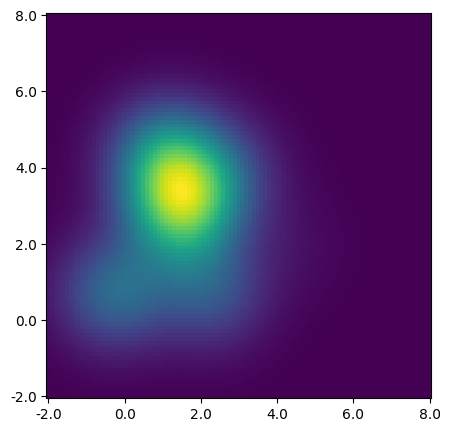

In [116]:
plt.style.use('default')
MoG_plot(pi[0], mu[0], cov[0])

In [117]:
time

[37.514862060546875, 30.84552550315857]

## Losses

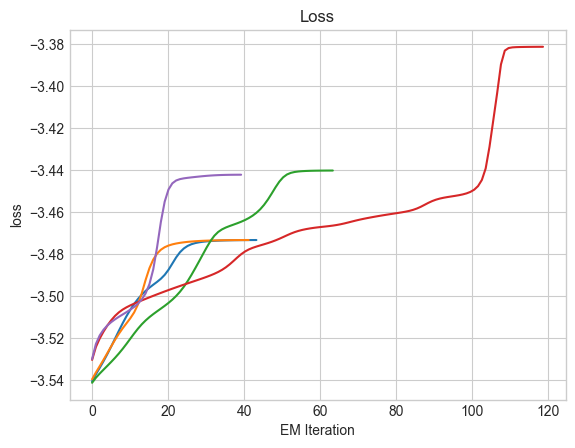

In [108]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

plt.title("Loss")
plt.xlabel("EM Iteration")
plt.ylabel("loss");
x = np.linspace(0, 180, 180)
for loss in d_loss:
    ax.plot(x[:len(loss)-1], loss[1:])


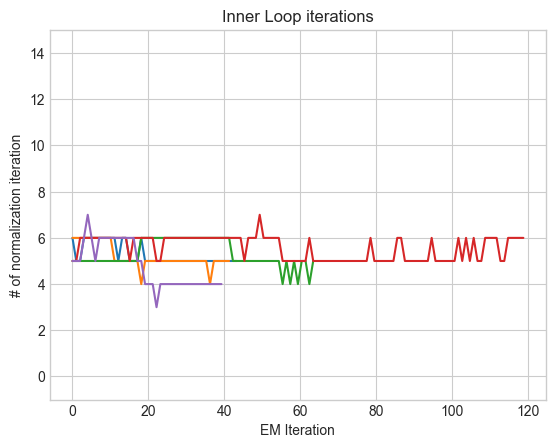

In [109]:
fig = plt.figure()
ax = plt.axes()

plt.ylim(-1, 15);
plt.title("Inner Loop iterations")
plt.xlabel("EM Iteration")
plt.ylabel("# of normalization iteration");
x = np.linspace(0, 180, 180)
for i in iters:
    ax.plot(x[:len(i)], i)


## True Distribution

In [37]:
data_fname = 'data_multi_adv.npz'
load_data = np.load(data_fname)
# true_pi = load_data['pi']
true_pi = np.ones(5) / 5.0
true_mu = load_data['mu']
samples = load_data['samples']
adv_sample = load_data['adv_sample']

In [38]:
true_pi

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [39]:
true_mu

array([[1., 1.],
       [1., 5.],
       [3., 3.],
       [5., 1.],
       [5., 5.]])

In [119]:
print(MoG_prob(np.array((1, 3)), true_pi, true_mu))
print(MoG_prob(np.array((3, 1)), true_pi, true_mu))
print(MoG_prob(np.array((1, 1)), true_pi, true_mu))
print(MoG_prob(np.array((3, 3)), true_pi, true_mu))
print(MoG_prob(np.array((5, 5)), true_pi, true_mu))

0.011397077640194667
0.01167676173401176
0.016037191368298117
0.04263940473635905
0.04505723715872976


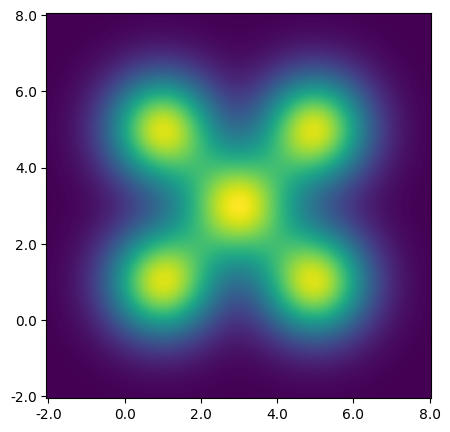

In [42]:
plt.style.use('default')
MoG_plot(true_pi, true_mu)

0.06490553330314895
0.11256231503061162
0.013969058705653124
0.06849927513972712
0.07085386166129576
0.025567829928906657
0.04417940800343305
0.07270774679821085
0.03259669480401742
0.039707449324319695
0.0834946554177684
0.023732270604221454


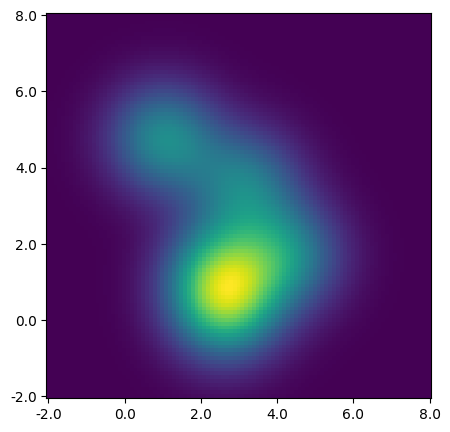

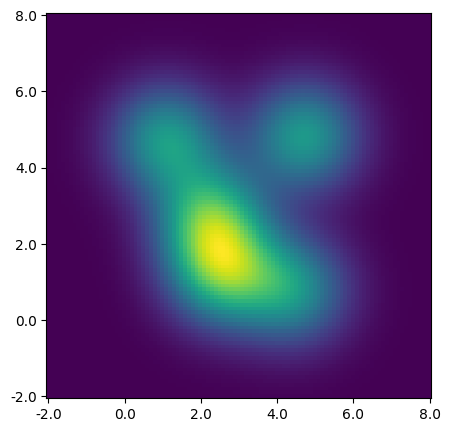

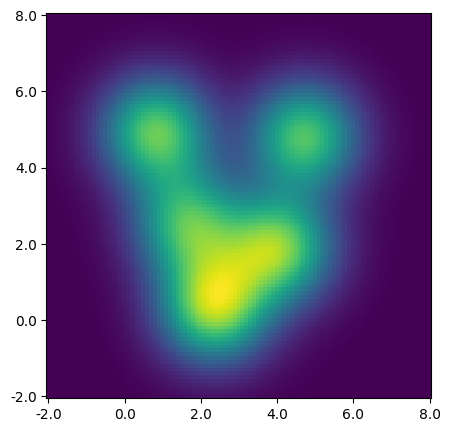

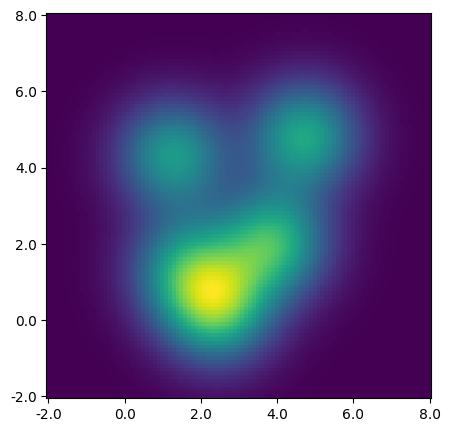

In [97]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i], cov[i])

## Pen-EM Results

In [108]:
#K=5-lam=0.1
pi, mu, cov, p_loss, d_loss, iters, time = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=10-lam=1.0-N=100.p")
pi

[array([0.0900266 , 0.10559553, 0.06483004, 0.12078863, 0.17142164,
        0.02918373, 0.08311857, 0.12405128, 0.05502646, 0.15595753]),
 array([0.02973991, 0.08687555, 0.25691716, 0.07435054, 0.04136097,
        0.03967963, 0.15587784, 0.11889044, 0.08154657, 0.11476137])]

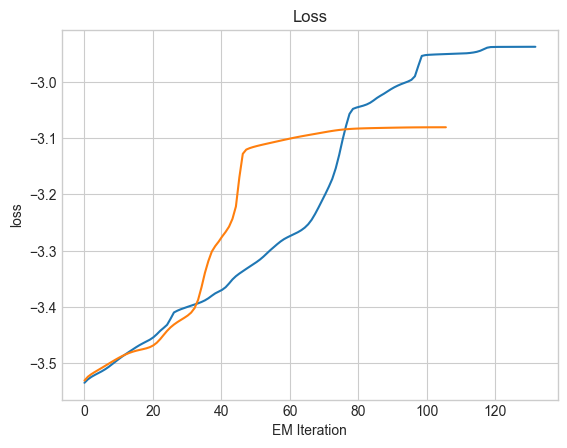

In [109]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

plt.title("Loss")
plt.xlabel("EM Iteration")
plt.ylabel("loss");
x = np.linspace(0, 200, 200)
for loss in d_loss:
    ax.plot(x[:len(loss)-1], loss[1:])

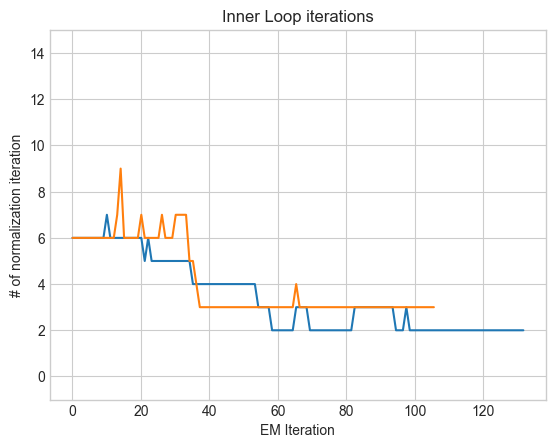

In [110]:
fig = plt.figure()
ax = plt.axes()

plt.ylim(-1, 15);
plt.title("Inner Loop iterations")
plt.xlabel("EM Iteration")
plt.ylabel("# of normalization iteration");
x = np.linspace(0, 180, 180)
for i in iters:
    ax.plot(x[:len(i)], i)

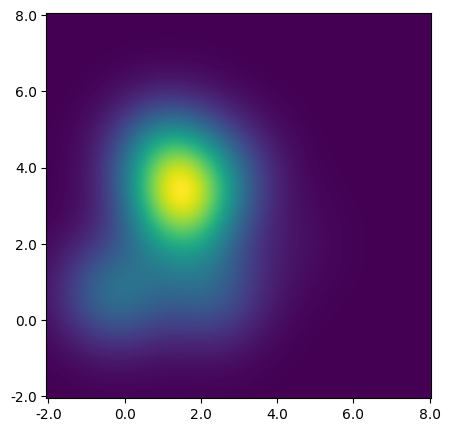

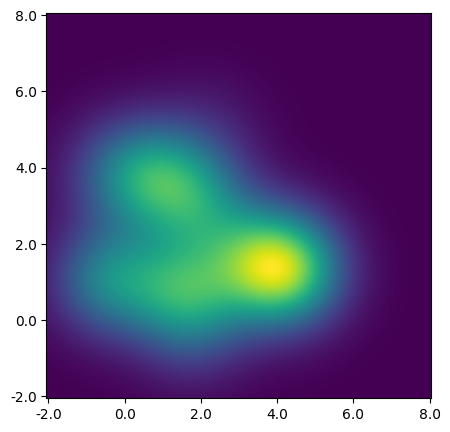

In [111]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i], cov[i])

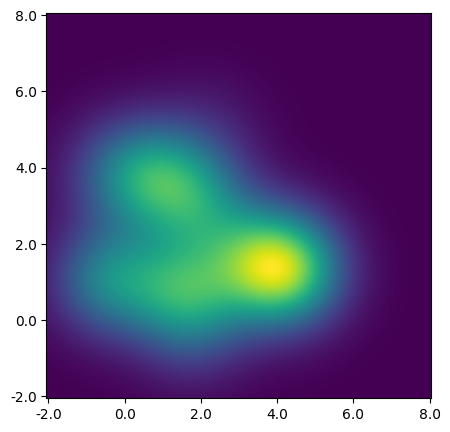

In [112]:
_i = 1
MoG_plot(pi[_i], mu[_i], cov[_i])
plt.savefig('Penalized-K=10-lam=1.0-N=100.png')

In [113]:
_i = 1
print(MoG_prob(np.array((1, 3)), pi[_i], mu[_i], cov[_i]))
print(MoG_prob(np.array((3, 1)), pi[_i], mu[_i], cov[_i]))
print(MoG_prob(np.array((3, 5)), pi[_i], mu[_i], cov[_i]))
print(MoG_prob(np.array((5, 3)), pi[_i], mu[_i], cov[_i]))

0.6344428164604775
0.17652109353594705
0.13527084170810602
0.018635466412348683


## Original EM Results

In [114]:
pi, mu, cov, loss, iters, time, init_guess = import_result_EM("results_multi_adv_EM/EM-K=10-lam=1.0-N=100.p")
pi

[array([0.09002728, 0.10559712, 0.06481673, 0.12078613, 0.17145394,
        0.02918375, 0.08311822, 0.12405275, 0.05503361, 0.15593048]),
 array([0.02974153, 0.08640361, 0.25803944, 0.07410844, 0.04136557,
        0.03968555, 0.15595178, 0.11645363, 0.0814208 , 0.11682965]),
 array([0.09388652, 0.11924442, 0.02775321, 0.19865071, 0.11993437,
        0.03013569, 0.02997333, 0.25698438, 0.02994973, 0.09348764])]

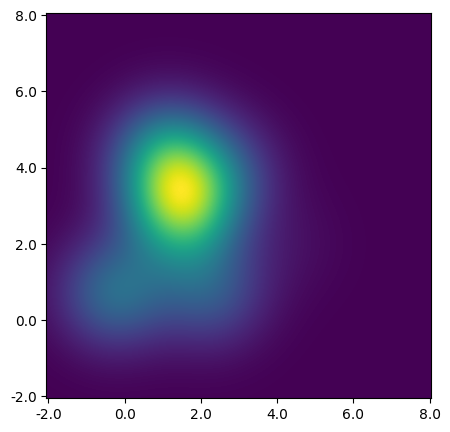

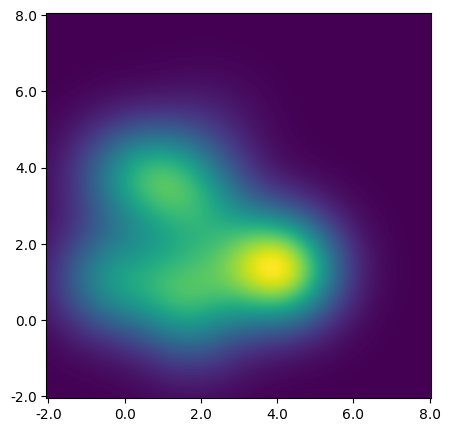

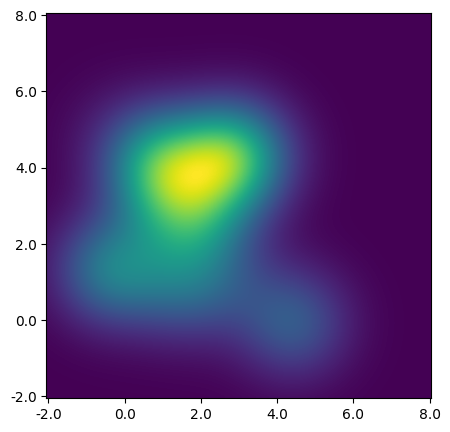

In [115]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i], cov[i])

In [ ]:
_i = 1
MoG_plot(pi[_i], mu[_i], cov[_i])
plt.savefig('EM-K=10-lam=1.0-N=100.png')

In [ ]:
_i = 1
print(MoG_prob(np.array((1, 3)), pi[_i], mu[_i], cov[_i]))
print(MoG_prob(np.array((3, 1)), pi[_i], mu[_i], cov[_i]))
print(MoG_prob(np.array((3, 5)), pi[_i], mu[_i], cov[_i]))
print(MoG_prob(np.array((5, 3)), pi[_i], mu[_i], cov[_i]))

## GD Results

In [73]:
pi, mu, cov, p_loss, d_loss = import_result_GD("results_multi_adv/result-adv-gd-K=5-lam=1.0-id=1.npz")
# plt.style.use('default')
# MoG_plot(pi, mu, cov)

In [74]:
pi

array([0.03741683, 0.13708115, 0.00084901, 0.35827494, 0.46637806],
      dtype=float32)

In [75]:
mu

array([[ 0.6906346,  1.4425582],
       [ 1.5391155,  0.5360932],
       [ 1.7381065, -1.3107198],
       [ 4.740739 ,  2.9442751],
       [ 2.0273066,  3.171319 ]], dtype=float32)

In [76]:
cov

array([[[ 0.00929648,  0.05640403],
        [ 0.05640403,  0.63699704]],

       [[ 0.9389926 , -0.02277673],
        [-0.02277673,  0.09198475]],

       [[ 1.0205669 ,  0.3812982 ],
        [ 0.3812982 ,  3.6499174 ]],

       [[ 0.62718093, -0.13569957],
        [-0.13569957,  3.0554225 ]],

       [[ 1.184568  , -1.1191378 ],
        [-1.1191378 ,  2.3077898 ]]], dtype=float32)

In [77]:
# print(MoG_prob(np.array((1, 1)), pi, mu, cov))
print(MoG_prob(np.array((1, 3)), pi, mu, cov))
print(MoG_prob(np.array((3, 1)), pi, mu, cov))
print(MoG_prob(np.array((3, 5)), pi, mu, cov))
print(MoG_prob(np.array((5, 3)), pi, mu, cov))

0.06753101511283052
0.034279324234395794
0.008243015782955342
0.04065704483627229


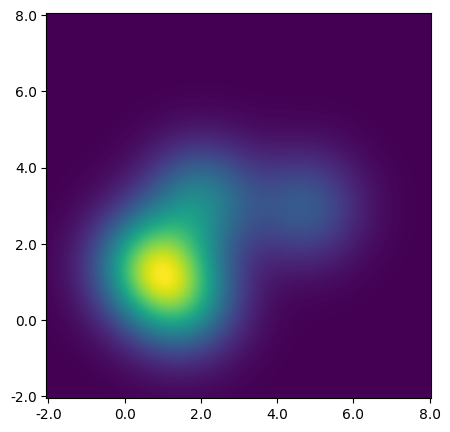

In [78]:
MoG_plot(pi, mu, cov)
plt.savefig('GD-K=5-lam=1.0-N=100.png')

## KL calculation

In [49]:
pi_GD, mu_GD, cov_GD, _, _ = import_result_GD("results_multi_adv/result-adv-gd-K=5-lam=1.0-id=1.npz")
pi_EM, mu_EM, cov_EM, _, _, _, _ = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=1.0-N=500.p")

True_P = lambda x : MoG_prob(x, true_pi, true_mu)
GD_P = lambda x : MoG_prob(x, pi_GD, mu_GD, cov_GD)
EM_P = lambda x : MoG_prob(x, pi_EM[0], mu_EM[0], cov_EM[0])

print(True_P(np.array((3, 3))))
print(GD_P(np.array((3, 3))))
print(EM_P(np.array((3, 3))))

0.034128879311090536
0.049815036264830324
0.06490553330314895


In [50]:
print(calc_KL(GD_P, True_P, np.linspace(-2, 8, 101)))
print(calc_KL(EM_P, True_P, np.linspace(-2, 8, 101)))

0.6144404318051818
0.4591656763476733


In [51]:
# correct KL: P = true, Q = estimation
print(calc_KL(True_P, GD_P, np.linspace(-2, 8, 101)))
print(calc_KL(True_P, EM_P, np.linspace(-2, 8, 101)))

1.1288661998266574
0.7106249987246043


0.049815036264830324
0.031540373663560266
0.05065356455347356
0.06490553330314895
0.11256231503061162
0.013969058705653124


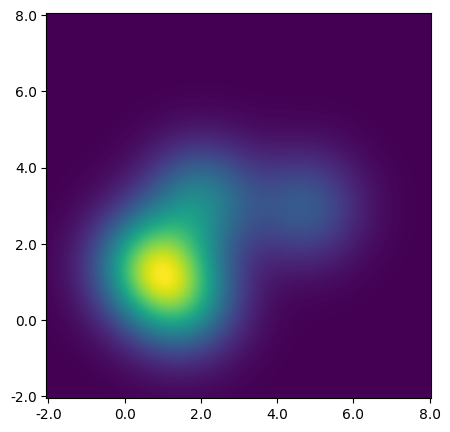

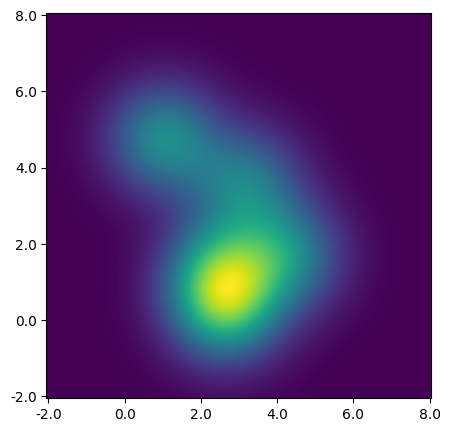

In [34]:
plt.style.use('default')
MoG_plot(pi_GD, mu_GD, cov_GD)
MoG_plot(pi_EM[0], mu_EM[0], cov_EM[0])

In [14]:
K = 3
lam = 0.1
GD_KL_list = []
for i in range(3):
    try:
        pi_GD, mu_GD, cov_GD, _, _ = import_result_GD("results_multi_adv/result-adv-gd-K={}-lam={}-id={}.npz".format(K, lam, i+1))
    except:
        break
    True_P = lambda x : MoG_prob(x, true_pi, true_mu)
    GD_P = lambda x : MoG_prob(x, pi_GD, mu_GD, cov_GD)
    KL = calc_KL(True_P, GD_P, np.linspace(-2, 8, 101))
    print(KL)
    GD_KL_list.append(KL)

GD_KL_avg = sum(GD_KL_list) / len(GD_KL_list)
GD_KL_avg

1.7406280884283503
1.8820489348364926
2.8217335529515513


2.148136858738798

## KL calculation

In [118]:
lam_settings = [0.1, 1.0, 10.0]
K_settings = [3, 5, 10]
all_settings = [(K, lam) for lam in lam_settings for K in K_settings]

for K, lam in all_settings:
    print('K = {}, lam = {}'.format(K, lam))
    GD_KL_list = []
    for i in range(3):
        try:
            pi_GD, mu_GD, cov_GD, _, _ = import_result_GD("results_multi_adv/result-adv-gd-K={}-lam={}-id={}.npz".format(K, lam, i+1))
        except:
            break
        True_P = lambda x : MoG_prob(x, true_pi, true_mu)
        GD_P = lambda x : MoG_prob(x, pi_GD, mu_GD, cov_GD)
        KL = calc_KL(True_P, GD_P, np.linspace(-2, 8, 101))
        print(KL)
        GD_KL_list.append(KL)
    if len(GD_KL_list) > 0:
        GD_KL_avg = sum(GD_KL_list) / len(GD_KL_list)
        print('GD_KL_avg = {}'.format(GD_KL_avg))

    EM_KL_list = []
    pi_EM, mu_EM, cov_EM, _, _, _, _ = import_result_penalizedEM("results_multi_adv_EM/Penalized-K={}-lam={}-N=100.p".format(K, lam))
    for i in range(len(pi_EM)):
        True_P = lambda x : MoG_prob(x, true_pi, true_mu)
        EM_P = lambda x : MoG_prob(x, pi_EM[i], mu_EM[i], cov_EM[i])
        KL = calc_KL(True_P, EM_P, np.linspace(-2, 8, 101))
        print(KL)
        EM_KL_list.append(KL)

    EM_KL_avg = sum(EM_KL_list) / len(EM_KL_list)
    print('EM_KL_avg = {}'.format(EM_KL_avg))

K = 3, lam = 0.1
1.4127025075341004
1.5269063327726151
2.3926917456014203
GD_KL_avg = 1.7774335286360454
1.8274269655739792
1.8279032277051939
2.6046520513103064
1.836743358029903
1.8514051204637731
EM_KL_avg = 1.9896261446166315
K = 5, lam = 0.1
2.7147940923368785
2.4205852801443455
2.0515676697422927
GD_KL_avg = 2.3956490140745057
1.5170180877881858
2.267869264551785
1.5793629029824539
1.959361797626132
1.516286391783476
EM_KL_avg = 1.7679796889464066
K = 10, lam = 0.1
2.3661578697603924
GD_KL_avg = 2.3661578697603924
1.3556667525546433
1.1748855006035928
1.0171630128731457
EM_KL_avg = 1.1825717553437938
K = 3, lam = 1.0
0.9627112455381378
0.9539273290110948
1.5480176309140716
GD_KL_avg = 1.1548854018211012
1.9738475071007127
1.9974233283092429
1.8294594250556147
2.2138176466569837
1.8552401569401256
EM_KL_avg = 1.973957612812536
K = 5, lam = 1.0
1.1288661998266574
2.473025368631172
2.8035087896517554
GD_KL_avg = 2.135133452703195
1.121314815101444
1.9593595624231341
1.88338564642355

In [119]:
for K, lam in all_settings:
    print('K = {}, lam = {}'.format(K, lam))
    
    EM_KL_list = []
    pi_EM, mu_EM, cov_EM, _, _, _, _ = import_result_EM("results_multi_adv_EM/EM-K={}-lam={}-N=100.p".format(K, lam))
    for i in range(len(pi_EM)):
        True_P = lambda x : MoG_prob(x, true_pi, true_mu)
        EM_P = lambda x : MoG_prob(x, pi_EM[i], mu_EM[i], cov_EM[i])
        KL = calc_KL(True_P, EM_P, np.linspace(-2, 8, 101))
        print(KL)
        EM_KL_list.append(KL)

    EM_KL_avg = sum(EM_KL_list) / len(EM_KL_list)
    print('EM_KL_avg = {}'.format(EM_KL_avg))

K = 3, lam = 0.1
1.8274893335917568
1.8278975154074224
2.6046625955254044
1.836764679133537
1.8518852511708892
EM_KL_avg = 1.989739874965802
K = 5, lam = 0.1
1.5170627432093444
2.267851385799311
1.5786552037621413
1.9568609932409073
1.5162922388036157
EM_KL_avg = 1.767344512963064
K = 10, lam = 0.1
1.336843894901335
1.1748556155187422
1.0259059647749544
EM_KL_avg = 1.1792018250650105
K = 3, lam = 1.0
1.9735592233392034
1.9973538422409587
1.829438610011884
2.2138143283056344
1.8552625476088274
EM_KL_avg = 1.9738857103013019
K = 5, lam = 1.0
1.1213160179113177
1.959406912539522
1.8828616121097586
2.0084350253733985
2.1334350508285906
EM_KL_avg = 1.8210909237525172
K = 10, lam = 1.0
1.253986366969659
1.009615219349057
0.6823667405540033
EM_KL_avg = 0.9819894422909062
K = 3, lam = 10.0
1.5838158247962795
2.2138289712400576
2.0958393899617116
1.6466483290844403
1.8264685023006044
EM_KL_avg = 1.8733202034766188
K = 5, lam = 10.0
2.026339578586255
1.7793043299039775
1.769222512580948
1.951455